**Student ID:** s225722032

**Student Name:** Phani Kiran Hemadri

**Workshop/Lab Session Time:**

In [1]:
#!pip -q install pyspark

#from google.colab import files

#uploaded = files.upload()


In [2]:
import os, glob
from google.colab import drive

print(os.getcwd())
drive.mount('/content/drive')

#!ls -lah '/content/drive/MyDrive/Colab Notebooks/business_review_submission'

file_dir='/content/drive/MyDrive/Colab Notebooks/business_review_submission'
glob.glob(os.path.join(file_dir, "*.csv"))


/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/Colab Notebooks/business_review_submission/review.csv',
 '/content/drive/MyDrive/Colab Notebooks/business_review_submission/meta-review-business.csv']

In [3]:
reviews_path = f"{file_dir}/review.csv"
meta_path    = f"{file_dir}/meta-review-business.csv"

In [4]:
# start Spark session

from pyspark.sql import SparkSession

spark = (
    SparkSession
        .builder
        .appName("SIT742-SparkSQL")
        .getOrCreate()
)

In [5]:
df_reviews = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(reviews_path)
)

df_meta = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv(meta_path)
)

df_reviews.show()

df_meta.show()

+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+----+--------------------+
|             user_id|                name|         time|              rating|                text|                pics|resp|             gmap_id|
+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+----+--------------------+
|1.091298048426862...|          Nicki Gore|1566331951619|                   5|We always stay he...|                NULL|NULL|0x56b646ed2220b77...|
|1.132409264057589...|       Allen Ratliff|1504917982385|                   5|Great campground ...|                NULL|NULL|0x56b646ed2220b77...|
|1.130448378911412...|   Jonathan Tringali|1474765901185|                   4|We tent camped he...|                NULL|NULL|                NULL|
|There is a bath h...| 2 restrooms (sin...|       toilet| shower). The hot...| but they lack ve...|                NUL

In [6]:
# Register temp views
df_reviews.createOrReplaceTempView("reviews_raw")
df_meta.createOrReplaceTempView("meta_raw")

# Question 1.1

Using PySpark to do some data wrangling process, so that


## 1.1.1
For the **none** or **null** in ***text column***, change it to '**no review**'.

In [7]:
# confirm presence of 'text' column
df_reviews.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)



In [8]:
# using spark sql query peek at rows that are null/empty/'none' before cleaning
spark.sql("""
SELECT *
FROM reviews_raw
WHERE text IS NULL
   OR TRIM(text) = ''
   OR LOWER(TRIM(text)) IN ('none', 'null')
""").show(n=5)


+--------------------+-------------+-------------+--------------------+----+----+----+--------------------+
|             user_id|         name|         time|              rating|text|pics|resp|             gmap_id|
+--------------------+-------------+-------------+--------------------+----+----+----+--------------------+
|Wi-Fi didn't reac...|         NULL|         NULL|0x56b646ed2220b77...|NULL|NULL|NULL|                NULL|
|1.169785198939306...|   Holly Anne|1629595392534|                   4|NULL|NULL|NULL|0x56c8992b5dee722...|
|1.097489809617870...|Emma Forsberg|1629598102068|                   5|NULL|NULL|NULL|0x56c8992b5dee722...|
|1.069279219833724...|sherry miller|1630540491895|                   5|NULL|NULL|NULL|0x56c8992b5dee722...|
|1.176554580456088...|     Amy Lieb|1630292802235|                   4|NULL|NULL|NULL|0x56c8992b5dee722...|
+--------------------+-------------+-------------+--------------------+----+----+----+--------------------+
only showing top 5 rows



In [9]:
# replace None/null/""/"none" in text with "no review"
# create new temp view 'review_clean' adding new column 'text_clean'

spark.sql("""
CREATE OR REPLACE TEMP VIEW reviews_clean AS
SELECT
  *,
  CASE
    WHEN text IS NULL
      OR TRIM(text) = ''
      OR LOWER(TRIM(text)) IN ('none', 'null')
    THEN 'no review'
    ELSE text
  END AS text_clean
FROM reviews_raw
""")




DataFrame[]

In [10]:
# peek few rows after cleaning null/none 'text' column with 'no review'
spark.sql("""
SELECT user_id, name, text AS original_text, text_clean
FROM reviews_clean
""").show(n=5)

+--------------------+--------------------+--------------------+--------------------+
|             user_id|                name|       original_text|          text_clean|
+--------------------+--------------------+--------------------+--------------------+
|1.091298048426862...|          Nicki Gore|We always stay he...|We always stay he...|
|1.132409264057589...|       Allen Ratliff|Great campground ...|Great campground ...|
|1.130448378911412...|   Jonathan Tringali|We tent camped he...|We tent camped he...|
|There is a bath h...| 2 restrooms (sin...| but they lack ve...| but they lack ve...|
|Wi-Fi didn't reac...|                NULL|                NULL|           no review|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [11]:
# print count of replaced items
spark.sql("""
SELECT COUNT(*) AS replaced_count
FROM reviews_clean
WHERE text_clean = 'no review'
""").show()

+--------------+
|replaced_count|
+--------------+
|        249931|
+--------------+



## 1.1.2
Process the content in time column, and convert the strings from time to **yyyy-mm-dd** format in the new column as newtime and show the first 5 rows.

In [12]:
# lets look at schema so we see column names and types
spark.sql("DESCRIBE TABLE reviews_clean").show()

+----------+---------+-------+
|  col_name|data_type|comment|
+----------+---------+-------+
|   user_id|   string|   NULL|
|      name|   string|   NULL|
|      time|   string|   NULL|
|    rating|   string|   NULL|
|      text|   string|   NULL|
|      pics|   string|   NULL|
|      resp|   string|   NULL|
|   gmap_id|   string|   NULL|
|text_clean|   string|   NULL|
+----------+---------+-------+



In [13]:
# lets review the lengths of 'time' strings
# In general milli seconds epoch string will be of length 13
# other lengths suggest improper data

spark.sql("""
SELECT
  LENGTH(time) AS len,
  COUNT(*)     AS cnt
FROM reviews_clean
GROUP BY LENGTH(time)
ORDER BY cnt DESC
""").show()

+----+------+
| len|   cnt|
+----+------+
|  13|521573|
|NULL| 24815|
| 112|   138|
| 224|    80|
|  40|    74|
|  42|    70|
|  20|    69|
|  14|    68|
|  18|    68|
|   6|    66|
|   7|    66|
|  21|    64|
|   5|    62|
|  41|    62|
|  11|    62|
|  44|    61|
| 336|    61|
|  39|    60|
|  23|    60|
|  29|    59|
+----+------+
only showing top 20 rows



In [14]:
# lets create a view that adds a column 'newtime' formatted as yyyy-MM-dd
spark.sql("""
CREATE OR REPLACE TEMP VIEW reviews_with_newtime AS
SELECT
  t.*,
  date_format(
    to_timestamp(
      from_unixtime( CAST(CAST(t.time AS BIGINT) / 1000 AS BIGINT) )
    ),
    'yyyy-MM-dd'
  ) AS newtime
FROM reviews_clean t
""")

DataFrame[]

In [15]:
# lets view original 'time' vs 'newtime' in yyyy-MM-dd format
spark.sql("""
SELECT user_id, name, time, newtime
FROM reviews_with_newtime
""").show(n=5)

# count rows where parsing failed and newtime is NULL
spark.sql("""
SELECT COUNT(*) AS null_newtime_count
FROM reviews_with_newtime
WHERE newtime IS NULL
""").show()

+--------------------+--------------------+-------------+----------+
|             user_id|                name|         time|   newtime|
+--------------------+--------------------+-------------+----------+
|1.091298048426862...|          Nicki Gore|1566331951619|2019-08-20|
|1.132409264057589...|       Allen Ratliff|1504917982385|2017-09-09|
|1.130448378911412...|   Jonathan Tringali|1474765901185|2016-09-25|
|There is a bath h...| 2 restrooms (sin...|       toilet|      NULL|
|Wi-Fi didn't reac...|                NULL|         NULL|      NULL|
+--------------------+--------------------+-------------+----------+
only showing top 5 rows

+------------------+
|null_newtime_count|
+------------------+
|             31104|
+------------------+



# Question 1.2
Find out the information for gmap_id on the reviews. In order to achieve the above, some wrangling work is
required to be done:

## 1.2.1
Using pyspark to calculate the number of reviews per each unique gmap_id and save as float format in pyspark dataframe to show the top 5 rows.

In [16]:
from pyspark.sql import functions as F, types as T

# get dataframe handle to the SQL view created in 1.1.2
reviews_df = spark.table("reviews_with_newtime")

# exclude rows where gmap_id is null or empty
reviews_df = reviews_df.where(
    F.col("gmap_id").isNotNull() & (F.length(F.trim(F.col("gmap_id"))) > 0)
)

# group by gmap_id and count how many reviews
# and add the count as a floating point number
counts_df = (
    reviews_df
      .groupBy("gmap_id")
      .agg(F.count("*").alias("num_reviews_int"))
      .withColumn("num_reviews_float", F.col("num_reviews_int").cast(T.DoubleType()))
)

# create a temp view
counts_df.createOrReplaceTempView("reviews_per_gmap")

# show top 5 by review_count_float
counts_df.orderBy(F.desc("num_reviews_float")).show(n=5)

+--------------------+---------------+-----------------+
|             gmap_id|num_reviews_int|num_reviews_float|
+--------------------+---------------+-----------------+
|0x56c897b9ce6000d...|           2737|           2737.0|
|0x56c899d05892048...|           2555|           2555.0|
|0x56c897c63697ee3...|           2220|           2220.0|
|0x56c8965ee2fb87a...|           2202|           2202.0|
|0x56c89629bde7481...|           2156|           2156.0|
+--------------------+---------------+-----------------+
only showing top 5 rows



## 1.2.2
Transform the current pyspark dataframe to pandas dataframe (named as df) and create the column reivew_time with the information of review time on hours level. Print your df pandas dataframe with top 5 rows after creating the column review_time.

In [17]:
import pandas as pd

# convert to pandas
df = reviews_df.toPandas()

# create new column review_time with information of review time on hours level
# convert 'time' to numeric, coercing errors to NaN, then fill NaN with 0 before converting to int64
df["review_time"] = pd.to_datetime(pd.to_numeric(df["time"], errors='coerce').fillna(0).astype("int64"), unit="ms").dt.hour

# print top 5 rows
df.head()

,user_id,name,time,rating,text,pics,resp,gmap_id,text_clean,newtime,review_time
0,1.091298048426862e+20,Nicki Gore,1566331951619,5,We always stay here when in Valdez for silver ...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,We always stay here when in Valdez for silver ...,2019-08-20,20
1,1.1324092640575896e+20,Allen Ratliff,1504917982385,5,Great campground for the price. Nice hot unlim...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,Great campground for the price. Nice hot unlim...,2017-09-09,0
2,1.1032915514759202e+20,S Blad,1472858535682,4,"This place is just a few miles outside Valdez,...",None,None,0x56b646ed2220b77f:0xd8975e316de80952,"This place is just a few miles outside Valdez,...",2016-09-02,23
3,1.08989634908602e+20,Daniel Formoso,1529649811341,5,Probably the nicest and cleanest campground we...,None,None,0x56b646ed2220b77f:0xd8975e316de80952,Probably the nicest and cleanest campground we...,2018-06-22,6
4,1.1573886554879607e+20,Victoria Cook,1466170294782,5,"Great, slept like a bear. Clean, convenient, c...",None,None,0x56b646ed2220b77f:0xd8975e316de80952,"Great, slept like a bear. Clean, convenient, c...",2016-06-17,13


## 1.2.3
Using matplotlib or seaborn to draw some (two or more if possible)visualizations on the relationship between gmap_id and reivew_time. You could explore for example, what is the time people usually review? How many business is reviewed in the morning time etc. Please also discuss the insights you
are finding with your visualizations in the markdown cell. Please also include your findings and visualizations in the report.

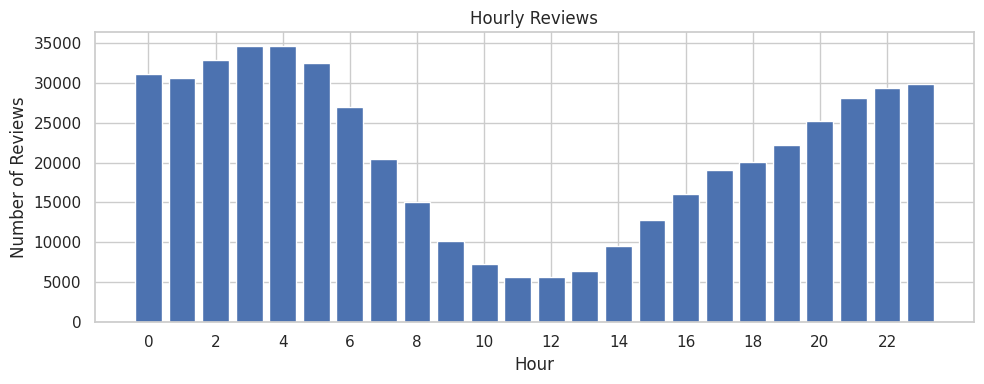

Unique businesses with morning review: 7382


/tmp/ipython-input-3021891356.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No morning review", "Has morning review"])


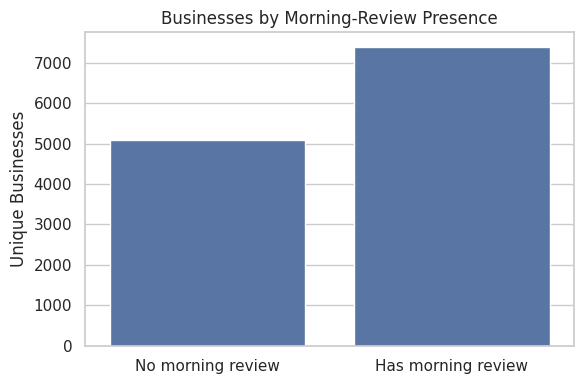

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")

# keep only rows with a valid hour and gmap_id
rt = pd.to_numeric(df["review_time"], errors="coerce")
df_rt = df.loc[rt.notna() & df["gmap_id"].notna(), ["gmap_id"]].copy()
df_rt["review_time"] = rt[rt.notna()].astype(int)

# What time do people usually review?
hour_counts = df_rt["review_time"].value_counts().sort_index()

plt.figure(figsize=(10, 4))
plt.bar(hour_counts.index, hour_counts.values)
plt.title("Hourly Reviews")
plt.xlabel("Hour")
plt.ylabel("Number of Reviews")
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

# How many businesses are reviewed in the morning time?
morning_mask = df_rt["review_time"].between(5, 12)
unique_morning_businesses = df_rt.loc[morning_mask, "gmap_id"].nunique()
print("Unique businesses with morning review:", unique_morning_businesses)

# build a per-business flag: does this business have any morning review?
biz_morning = (
    df_rt.assign(is_morning=morning_mask)
         .groupby("gmap_id", as_index=False)["is_morning"]
         .max()
)

plt.figure(figsize=(6, 4))
ax = sns.countplot(data=biz_morning, x="is_morning")
ax.set_title("Businesses by Morning-Review Presence")
ax.set_xlabel("")
ax.set_xticklabels(["No morning review", "Has morning review"])
ax.set_ylabel("Unique Businesses")
plt.tight_layout()
plt.show()



# Question 1.3

Let’s continue to analyze the reivew_time with reviews and related gmap_id. You need to use another data meta-business to join with the current dataframe on gmap_id.


## 1.3.1

 Determine which workday (day of the week), generates the most reviews (plotting the results in a line chart with workday on averaged submissions)

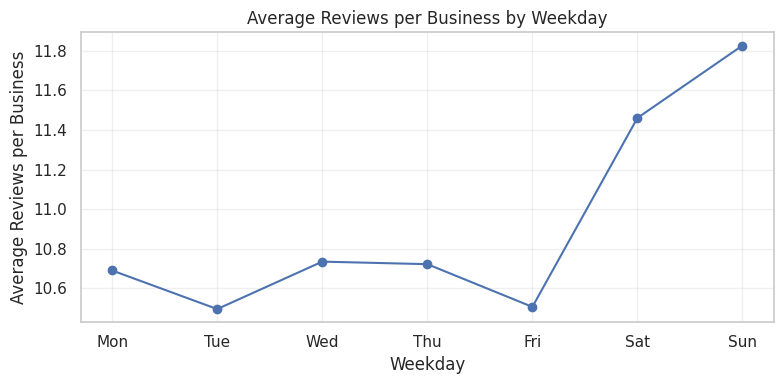

Highest average: Sun (11.83 reviews per business)


In [19]:
# load meta business view in to pandas
meta_df = spark.table("meta_raw").toPandas()

# join reviews with meta on gmap_id
df_joined = df.merge(meta_df, on="gmap_id", how="left")

# parse weekday from the review date
dates = pd.to_datetime(df_joined["newtime"], format="%Y-%m-%d", errors="coerce")
df_joined["weekday"]  = dates.dt.weekday
df_joined["day_name"] = dates.dt.day_name().str[:3]

# count reviews per gmap_id and weekday
review_count_gmap_weekday = (
    df_joined.dropna(subset=["gmap_id", "weekday"])
       .groupby(["gmap_id", "weekday", "day_name"], as_index=False)
       .size()
       .rename(columns={"size": "reviews_count"})
)

# average across businesses per weekday
business_avg_reviews_per_weekday = (
    review_count_gmap_weekday
      .groupby(["weekday", "day_name"], as_index=False)["reviews_count"]
      .mean()
      .rename(columns={"reviews_count": "avg_reviews_per_business"})
      .sort_values("weekday")
)

# line chart -- weekday on x, averaged submissions on y
plt.figure(figsize=(8, 4))
plt.plot(business_avg_reviews_per_weekday["day_name"],
         business_avg_reviews_per_weekday["avg_reviews_per_business"], marker="o")
plt.title("Average Reviews per Business by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Average Reviews per Business")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Determine which workday (day of the week), generates the most reviews
best_day = business_avg_reviews_per_weekday.loc[
    business_avg_reviews_per_weekday["avg_reviews_per_business"].idxmax()]
print(f"Highest average: {best_day['day_name']} ({best_day['avg_reviews_per_business']:.2f} reviews per business)")

## 1.3.2

Identify the names of business (column name from data meta-business) that has the highest averaged ratings on ‘that workday’ (you need to find out from 1.3.1), and find out which category those businesses are from?

In [20]:
print("df columns:", df.columns.tolist())
print("meta_df columns:", meta_df.columns.tolist())
print("df_joined columns:", df_joined.columns.tolist())

df columns: ['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id', 'text_clean', 'newtime', 'review_time']
meta_df columns: ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url']
df_joined columns: ['user_id', 'name_x', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id', 'text_clean', 'newtime', 'review_time', 'name_y', 'address', 'description', 'latitude', 'longitude', 'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'MISC', 'state', 'relative_results', 'url', 'weekday', 'day_name']


In [21]:
# filter reviews to best day from 1.3.1
target_weekday  = int(best_day["weekday"])
target_day_name = best_day["day_name"]
df_day = df_joined[df_joined["weekday"] == target_weekday].copy()

# convert ratings to numeric
df_day["rating_num"] = pd.to_numeric(df_day["rating"], errors="coerce")
print(f"{len(df_day)} reviews on {target_day_name} across {df_day['gmap_id'].nunique()} businesses.")

# Average rating per business on the target day
agg = (df_day
       .groupby(["gmap_id", "name_y", "category"], as_index=False)
       .agg(
           avg_rating_that_day=("rating_num", "mean"),
           reviews_that_day   =("rating_num", "count")
       ))

print(f"Aggregated {agg.shape[0]} businesses for {target_day_name}.")

# pick all businesses tied for the highest average rating
max_avg = agg["avg_rating_that_day"].max()
top_businesses = (agg.loc[agg["avg_rating_that_day"].eq(max_avg)].sort_values(["avg_rating_that_day", "reviews_that_day"], ascending=[False, False]))
top_businesses[["name_y", "gmap_id", "category", "avg_rating_that_day", "reviews_that_day"]].head(10)

77960 reviews on Sun across 6592 businesses.
Aggregated 5634 businesses for Sun.


,name_y,gmap_id,category,avg_rating_that_day,reviews_that_day
4900,All Creatures Veterinary Clinic,0x56c8e08ea9b4e989:0x78acdbd93a92a3dd,['Veterinarian'],5.0,22
1607,Little Mermaid,0x56c12c10624fa0a3:0x30c0b73bd82bcf1b,"['Seafood restaurant', 'American restaurant']",5.0,18
3926,Anchorage Ace Hardware,0x56c89869bfea62e3:0xf8778ab6f95058b5,"['Hardware store', 'Home improvement store', '...",5.0,16
2212,Winner Creek Gorge Trail Head (Lower Winner Cr...,0x56c864be40274793:0xafe08d3ac6f4d5d,"['Hiking area', 'Tourist attraction']",5.0,14
3557,Alaska Veterinary Clinic,0x56c897c931af014b:0x7ce8d189db1c8a1b,"['Veterinarian', 'Veterinary pharmacy']",5.0,13
5017,Bleeding Heart Brewery,0x56c8e27781137c49:0x1a7d7c5b7d55628d,['Brewery'],5.0,13
1893,Lucky Raven Tobacco,0x56c663ee84279121:0x37657b5a91a696ec,['Tobacco shop'],5.0,12
5040,Escape Anchorage,0x56c8e8d80099933b:0xe713b933ea9ad13,"['Escape room center', 'Entertainer']",5.0,12
2009,Kenai Veterinary Hospital,0x56c67c9ee8c294af:0x5ccab006ce0db3f6,"['Animal hospital', 'Veterinarian']",5.0,11
2205,Varly's Swiftwater Seafood Cafe,0x56c80c67ad848299:0x95b9aeb0da99ad5c,"['Seafood restaurant', 'Bar', 'Cafe']",5.0,11


## 1.3.3

Please further explore the data on name of business and find out some more insights by yourself such as which category it is and what are the peak hours etc. Please use visualizations and tables to support your findings and write down the insights in the markdown cell. Please also include your findings and
visualizations in the report.

Best day : Sun 
Categories for top 10 businesses


,name_y,gmap_id,category
4900,All Creatures Veterinary Clinic,0x56c8e08ea9b4e989:0x78acdbd93a92a3dd,['Veterinarian']
1607,Little Mermaid,0x56c12c10624fa0a3:0x30c0b73bd82bcf1b,"['Seafood restaurant', 'American restaurant']"
3926,Anchorage Ace Hardware,0x56c89869bfea62e3:0xf8778ab6f95058b5,"['Hardware store', 'Home improvement store', '..."
2212,Winner Creek Gorge Trail Head (Lower Winner Cr...,0x56c864be40274793:0xafe08d3ac6f4d5d,"['Hiking area', 'Tourist attraction']"
3557,Alaska Veterinary Clinic,0x56c897c931af014b:0x7ce8d189db1c8a1b,"['Veterinarian', 'Veterinary pharmacy']"
5017,Bleeding Heart Brewery,0x56c8e27781137c49:0x1a7d7c5b7d55628d,['Brewery']
1893,Lucky Raven Tobacco,0x56c663ee84279121:0x37657b5a91a696ec,['Tobacco shop']
5040,Escape Anchorage,0x56c8e8d80099933b:0xe713b933ea9ad13,"['Escape room center', 'Entertainer']"
2009,Kenai Veterinary Hospital,0x56c67c9ee8c294af:0x5ccab006ce0db3f6,"['Animal hospital', 'Veterinarian']"
2205,Varly's Swiftwater Seafood Cafe,0x56c80c67ad848299:0x95b9aeb0da99ad5c,"['Seafood restaurant', 'Bar', 'Cafe']"


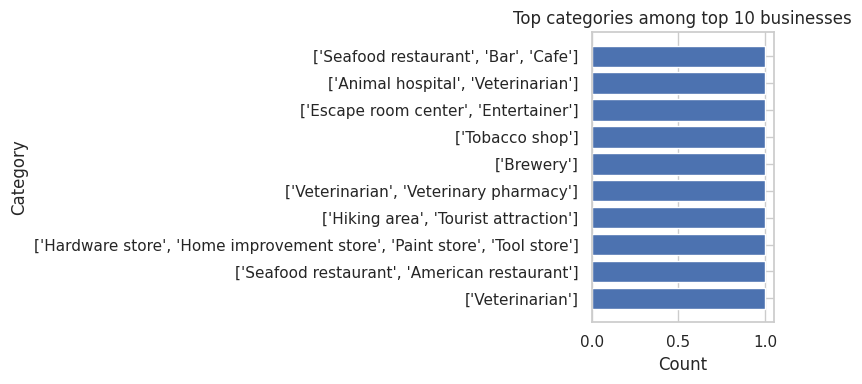

Peak hour per business:


,name_y,gmap_id,category,hour,reviews_at_hour
7,All Creatures Veterinary Clinic,0x56c8e08ea9b4e989:0x78acdbd93a92a3dd,['Veterinarian'],19,11
0,Little Mermaid,0x56c12c10624fa0a3:0x30c0b73bd82bcf1b,"['Seafood restaurant', 'American restaurant']",4,11
6,Anchorage Ace Hardware,0x56c89869bfea62e3:0xf8778ab6f95058b5,"['Hardware store', 'Home improvement store', '...",0,10
4,Winner Creek Gorge Trail Head (Lower Winner Cr...,0x56c864be40274793:0xafe08d3ac6f4d5d,"['Hiking area', 'Tourist attraction']",4,9
5,Alaska Veterinary Clinic,0x56c897c931af014b:0x7ce8d189db1c8a1b,"['Veterinarian', 'Veterinary pharmacy']",2,11
8,Bleeding Heart Brewery,0x56c8e27781137c49:0x1a7d7c5b7d55628d,['Brewery'],0,7
1,Lucky Raven Tobacco,0x56c663ee84279121:0x37657b5a91a696ec,['Tobacco shop'],3,11
9,Escape Anchorage,0x56c8e8d80099933b:0xe713b933ea9ad13,"['Escape room center', 'Entertainer']",2,16
2,Kenai Veterinary Hospital,0x56c67c9ee8c294af:0x5ccab006ce0db3f6,"['Animal hospital', 'Veterinarian']",21,11
3,Varly's Swiftwater Seafood Cafe,0x56c80c67ad848299:0x95b9aeb0da99ad5c,"['Seafood restaurant', 'Bar', 'Cafe']",4,12


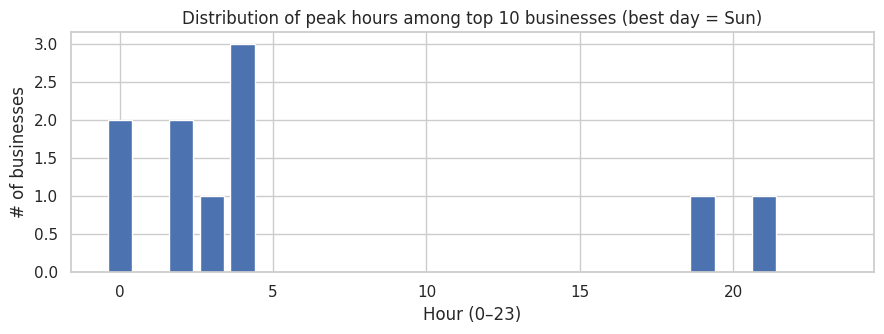

In [22]:
# business → category
focus = top_businesses.head(10).copy()
focus_categories = focus[["name_y", "gmap_id", "category"]]
print(f"Best day : {best_day['day_name']} \nCategories for top 10 businesses")
display(focus_categories)

# categories among top businesses
cat_simple = focus["category"].astype(str)
cat_counts = cat_simple.value_counts()

plt.figure(figsize=(8, 4))
plt.barh(cat_counts.index, cat_counts.values)
plt.title(f"Top categories among top {len(focus)} businesses")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()
# filter all reviews to the selected businesses
focus_ids = set(focus["gmap_id"])
tmp = df_joined[df_joined["gmap_id"].isin(focus_ids)].copy()

# ensure an hour column
tmp["hour"] = pd.to_numeric(tmp["review_time"], errors="coerce").astype("Int64")

# find the hour with the most reviews
peak = (tmp.dropna(subset=["hour"])
          .groupby(["gmap_id","hour"]).size()
          .reset_index(name="reviews_at_hour"))
peak_top = peak.loc[peak.groupby("gmap_id")["reviews_at_hour"].idxmax()]

# keep the same order as 'focus'
peak_tbl = peak_top.merge(focus[["gmap_id","name_y","category"]], on="gmap_id", how="left")
peak_tbl["gmap_id"] = pd.Categorical(peak_tbl["gmap_id"], categories=focus["gmap_id"], ordered=True)
peak_tbl = peak_tbl.sort_values("gmap_id")

print("Peak hour per business:")
display(peak_tbl[["name_y","gmap_id","category","hour","reviews_at_hour"]])

# how many of these businesses peak at each hour
peak_counts = peak_tbl["hour"].value_counts().reindex(range(24), fill_value=0).sort_index()

plt.figure(figsize=(9, 3.5))
plt.bar(peak_counts.index, peak_counts.values)
plt.title(f"Distribution of peak hours among top {len(focus)} businesses (best day = {best_day['day_name']})")
plt.xlabel("Hour (0–23)")
plt.ylabel("# of businesses")
plt.tight_layout()
plt.show()

# Question 1.4

For the reviews on each of the submissions, work on all the review content and find out the top 30 most
common words; Also generate separate word cloud visualizations for different years by grouping the
reviews by review year and write down the insights in the markdown cell. Please also include your findings
and visualizations in the report.

Top 30 most common words:
review          224030
the             216214
and             189000
great           78311
was             67853
for             64842
good            59745
food            58817
they            48087
place           43972
service         42359
you             41709
but             37094
very            35692
with            34125
are             33641
have            31842
this            30863
that            27118
staff           26528
not             26147
friendly        24829
nice            24645
there           22928
always          21929
had             21816
best            20282
here            19142
love            18813
get             17560


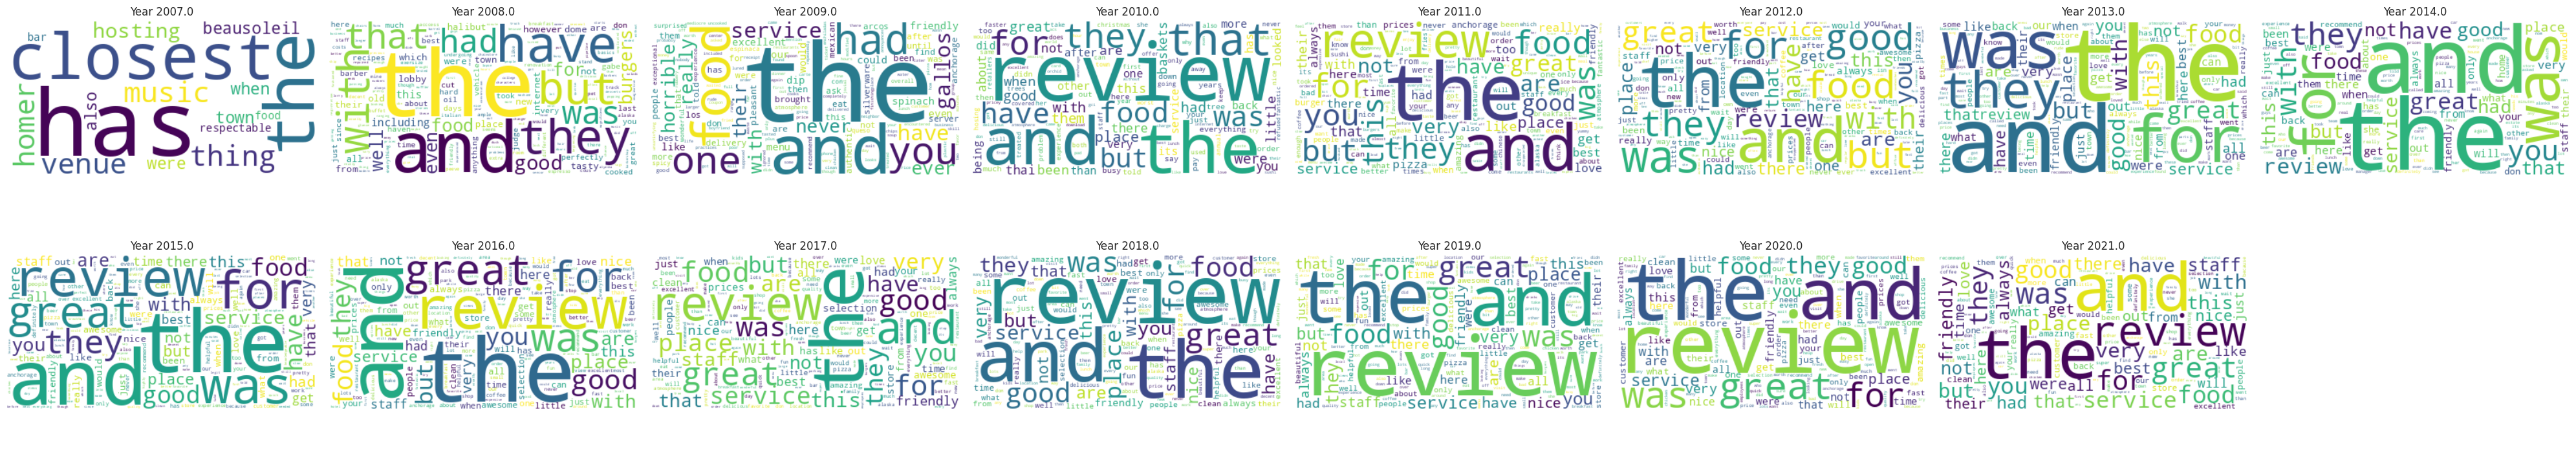

In [23]:
import math
import re
from collections import Counter
from wordcloud import WordCloud

reviews_text = df_joined.get("text_clean", df_joined["text"]).dropna().astype(str)

# simple tokenizer function
# to convert to lowercase, remove non-letters, split
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return [w for w in text.split() if len(w) > 2]

tokens = []
for t in reviews_text:
    tokens.extend(tokenize(t))

# get top 30 most common words
top30 = Counter(tokens).most_common(30)
print("Top 30 most common words:")
for word, count in top30:
    print(f"{word:15} {count}")

# prepare year column from 'newtime'
dates = pd.to_datetime(df_joined["newtime"], errors="coerce")
df_joined["year"] = dates.dt.year

# generate word clouds by year
years = sorted(df_joined["year"].dropna().unique())
n = len(years)
cols = 8
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))

for ax, yr in zip(axes.flat, years):
    texts = df_joined.loc[df_joined["year"] == yr, "text_clean"].dropna().astype(str)
    tokens_yr = []
    for t in texts:
        tokens_yr.extend(tokenize(t))
    freq_yr = Counter(tokens_yr)
    if not freq_yr:
        ax.axis("off")
        continue

    wc = WordCloud(width=400, height=200, background_color="white").generate_from_frequencies(freq_yr)
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Year {yr}")
    ax.axis("off")

# Hide empty subplots if any
for ax in axes.flat[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


# Question 1.5
Let’s do some analysis on the business_name and the reviewers. Determine the number of unique reviewers
of business and its categories to identify which business / category has attracted the most reviewers (find
out the highest distinct count of reviewers on business / category level). Also, analyze the temporal patterns
of when reviewers submitted their reviews (you could leverage the workday, year, month, or hours to
conduct the analysis) and share your findings and insights in the markdown cell. Please also include your
findings and insights (visualizations) in the report.

Top 10 businesses by unique reviewers:


,gmap_id,name_y,unique_reviewers
3600,0x56c897b9ce6000df:0xd707e127588a8c6c,Moose's Tooth Pub & Pizzeria,2737
4376,0x56c899d058920487:0x12882cc9133f2f54,Dimond Center,2504
3737,0x56c897c63697ee39:0x419904ababbc740b,Walmart Supercenter,2163
2888,0x56c8965ee2fb87a1:0x559736347bd48842,Costco Wholesale,2130
2660,0x56c89629bde7481f:0x7e8a9413ab25d5d,Anchorage 5th Avenue Mall,2054
4370,0x56c899cd61bbf82b:0x544a5b80b67a93c7,Costco Wholesale,1780
2470,0x56c8942639bddcf1:0x3d4151966bed9375,Tikahtnu Commons,1693
4374,0x56c899d0184538f9:0xfcf4420cda19d613,Walmart Supercenter,1686
4738,0x56c8bd86fd671871:0x52c896e66d960c02,49th State Brewing - Anchorage,1661
3016,0x56c8969817c5b323:0xfd52c71fe0d827f1,Walmart Supercenter,1558


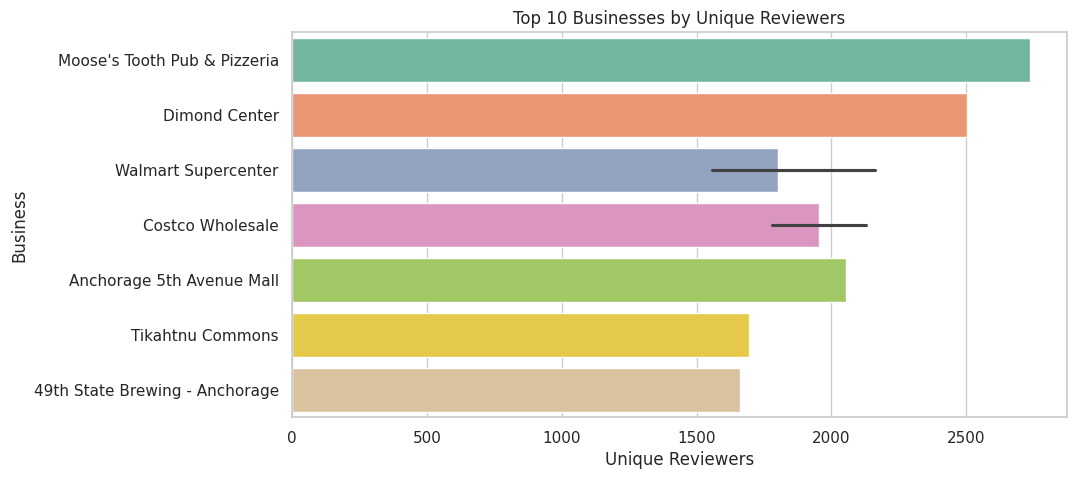

Top 10 categories by unique reviewers:


,category,unique_reviewers
2189,['Shopping mall'],7081
883,"['Department store', 'Clothing store', 'Craft ...",6976
1008,"['Fast food restaurant', 'Breakfast restaurant...",6857
1219,"['Grocery store', 'Grocery delivery service']",5698
1634,['Mexican restaurant'],4909
2529,"['Warehouse store', 'Department store']",4352
1007,"['Fast food restaurant', 'Breakfast restaurant...",4319
2081,['Restaurant'],4180
116,['American restaurant'],3791
1225,"['Grocery store', 'Propane supplier']",3401


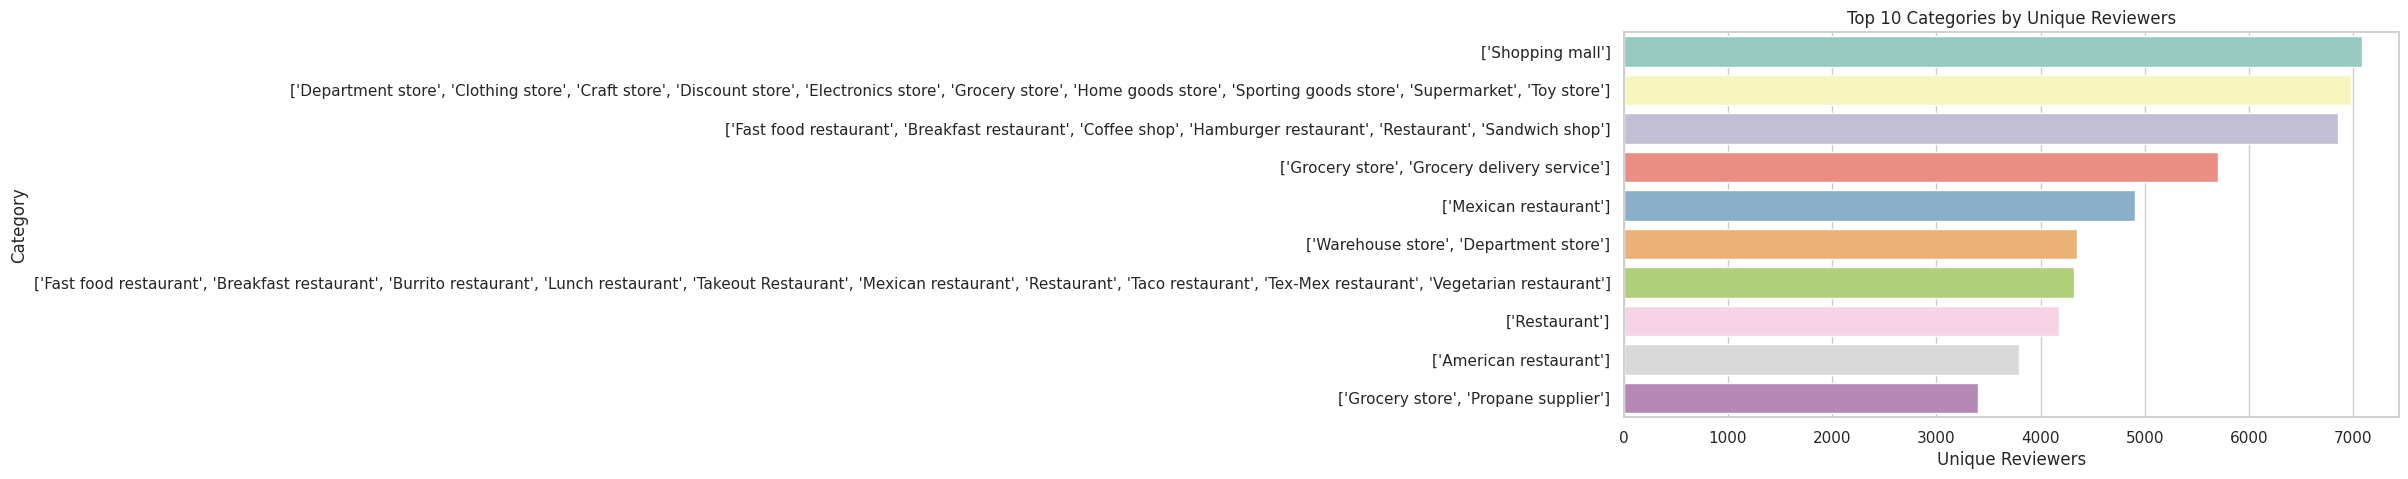

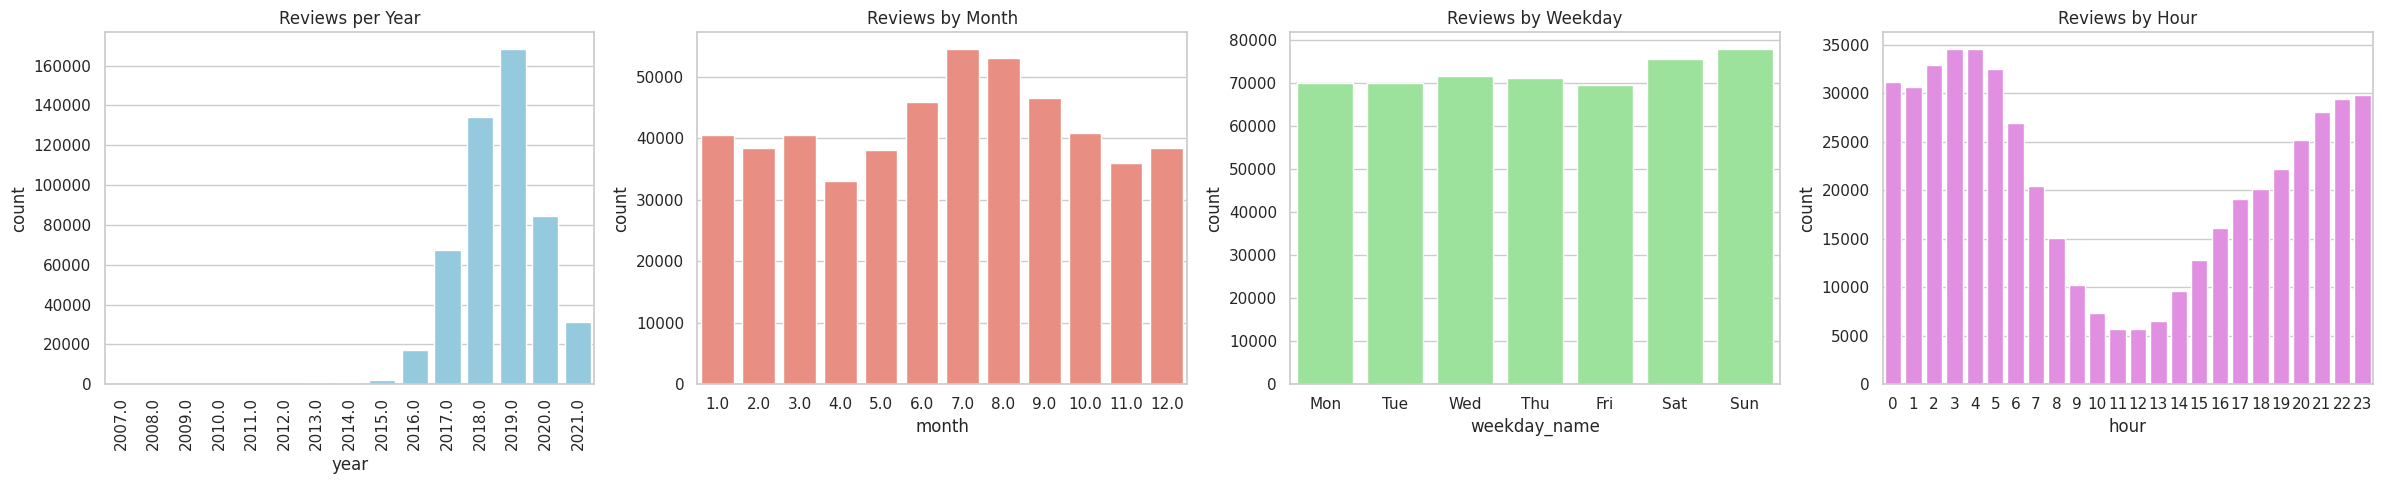

In [24]:
df_joined["rating_num"] = pd.to_numeric(df_joined["rating"], errors="coerce")

# Unique reviewers per business
reviewers_per_business = (
    df_joined.groupby(["gmap_id", "name_y"])
    ["user_id"].nunique()
    .reset_index(name="unique_reviewers")
    .sort_values("unique_reviewers", ascending=False)
)

print("Top 10 businesses by unique reviewers:")
display(reviewers_per_business.head(10))

plt.figure(figsize=(10,5))
sns.barplot(
    data=reviewers_per_business.head(10),
    x="unique_reviewers", y="name_y", hue="name_y",
    palette="Set2", legend=False
)
plt.title("Top 10 Businesses by Unique Reviewers")
plt.xlabel("Unique Reviewers")
plt.ylabel("Business")
plt.show()

# Unique reviewers per category
reviewers_per_category = (
    df_joined.groupby("category")["user_id"]
    .nunique()
    .reset_index(name="unique_reviewers")
    .sort_values("unique_reviewers", ascending=False)
)

print("Top 10 categories by unique reviewers:")
display(reviewers_per_category.head(10))

plt.figure(figsize=(10,5))
sns.barplot(
    data=reviewers_per_category.head(10),
    x="unique_reviewers", y="category", hue="category",
    palette="Set3", legend=False
)
plt.title("Top 10 Categories by Unique Reviewers")
plt.xlabel("Unique Reviewers")
plt.ylabel("Category")
plt.show()

# Temporal patterns
dates = pd.to_datetime(df_joined["newtime"], errors="coerce")
df_joined["year"] = dates.dt.year
df_joined["month"] = dates.dt.month
df_joined["weekday_name"] = dates.dt.day_name().str[:3]
df_joined["hour"] = pd.to_numeric(df_joined["review_time"], errors="coerce").astype("Int64")

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# Reviews per year
sns.countplot(data=df_joined, x="year", color="skyblue", ax=axes[0])
axes[0].set_title("Reviews per Year")
axes[0].tick_params(axis="x", rotation=90)

# Reviews per month
sns.countplot(data=df_joined, x="month", color="salmon", ax=axes[1])
axes[1].set_title("Reviews by Month")

# Reviews by weekday
sns.countplot(
    data=df_joined, x="weekday_name",
    order=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"],
    color="lightgreen", ax=axes[2]
)
axes[2].set_title("Reviews by Weekday")

# Reviews by hour
sns.countplot(data=df_joined, x="hour", color="violet", ax=axes[3])
axes[3].set_title("Reviews by Hour")

plt.tight_layout()
plt.show()


# Question 1.6
As the data scientist, you are required to build a recommendation for the business by using reviews, ratings,
and its categories. In this task, you need to:



## 1.6.1
Write down your strategy of building the recommendation on business for customers in the markdown
cell. You could create your own strategy or leverage the provided one here KNN on collaborative
filtering. Please also include your strategy details in the report.



**Strategy for Building Recommendation System**

To recommend businesses to customers, we will use a KNN on Collaborative Filtering approach based on reviews and ratings. The intuition is that customers with similar rating patterns are likely to enjoy similar businesses.

**Steps**:



*   Create a user–business matrix where rows are users, columns are businesses, and values are ratings.
*   Fill missing ratings with 0.
*   Use K-Nearest Neighbors to compute similarity between businesses.
*   Each business is represented by its column vector of ratings.
*   Businesses with similar rating patterns are considered neighbors.
*   For a given business, recommend the most similar businesses.


## 1.6.2
Could you please try to implement the strategy (code) you have written down for the recommendation
system? Please give detailed explanation of your code and the logic in the comments and also interpret
the recommendations with examples in the markdown cell. Please also include your implementation
details and results in the report.

User–Business matrix shape: (19975, 12134)

Recommendations for:    ""rock bottom"" price tags.....its the best place to shop for your aquarium needs in Alaska."



,business_id,similarity_score,name,category
0,0x56c79c79fd3b25eb:0xcc17a4dd4a0069ce,0.184506,"NAPA Auto Parts - Brooks Range Kenai, LLC.","['Auto parts store', 'Trailer supply store', '..."
1,0x56c79b8ef20ce4d3:0x5b0228a1cbbb377b,0.168580,Seward Ship's Ace Hardware and Marine,"['Hardware store', 'Home improvement store', '..."
2,0x56c8976fbd88c14d:0x9a8ce1ceeb42e340,0.140459,Really Neat Stuff,"['Glassware store', 'Custom t-shirt store', 'I..."
3,0x56c79c63b6fc0865:0x92aa6cdeb85c3aae,0.134687,Seward Alehouse,"['Bar', 'Liquor store']"
4,0x56c79c79e2b4ebe5:0xad516783d821476a,0.132236,Pit Bar & Liquor Store,"['Bar', 'Event venue', 'Liquor store']"


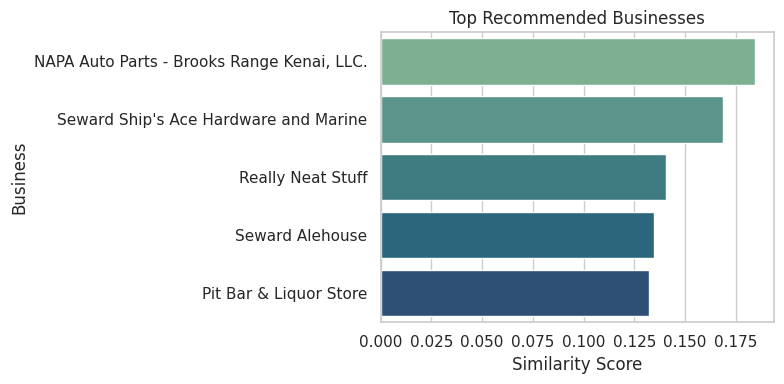

In [25]:
from sklearn.neighbors import NearestNeighbors

# Prepare the user–business matrix
ratings_df = df_joined[["user_id", "gmap_id", "rating"]].copy()
ratings_df["rating"] = pd.to_numeric(ratings_df["rating"], errors="coerce")

user_business_matrix = ratings_df.pivot_table(
    index="user_id", columns="gmap_id", values="rating"
).fillna(0)

print("User–Business matrix shape:", user_business_matrix.shape)

# Fit KNN model on businesses
business_matrix = user_business_matrix.T.values

model_knn = NearestNeighbors(metric="cosine", algorithm="brute")
model_knn.fit(business_matrix)

# Recommendation function
def recommend_business(business_id, top_n=5):
    """
    Recommend similar businesses to the given business_id
    with business name, category, and similarity score.
    """
    if business_id not in user_business_matrix.columns:
        print("Business not found in dataset.")
        return None

    idx = list(user_business_matrix.columns).index(business_id)
    business_vec = business_matrix[idx].reshape(1, -1)

    distances, indices = model_knn.kneighbors(business_vec, n_neighbors=top_n+1)

    similar_ids = [user_business_matrix.columns[i] for i in indices.flatten()][1:]
    similar_scores = distances.flatten()[1:]


    results = pd.DataFrame({
        "business_id": similar_ids,
        "similarity_score": 1 - similar_scores
    })

    results = results.merge(
        meta_df[["gmap_id", "name", "category"]],
        left_on="business_id", right_on="gmap_id", how="left"
    ).drop(columns="gmap_id")

    return results

# example recommendation
example_business = user_business_matrix.columns[0]
recos = recommend_business(example_business, top_n=5)

print(f"\nRecommendations for: {example_business}\n")
display(recos)

# visualization
plt.figure(figsize=(8,4))
sns.barplot(data=recos, x="similarity_score", y="name", hue="name",
            palette="crest", legend=False)
plt.title("Top Recommended Businesses")
plt.xlabel("Similarity Score")
plt.ylabel("Business")
plt.tight_layout()
plt.show()


**Insights from Recommendation System**

The system builds a user-business rating matrix and applies KNN with cosine similarity to identify businesses that attract similar reviewers.

In the example shown above, the query business produces recommendations such as:

*   NAPA Auto Parts - Brooks Range Kenai, LLC
*   Seward Ship's Ace Hardware and Marine
*   Really Neat Stuff
*   Seward Alehouse
*   Pit Bar & Liquor Store

These recommendations span different but related categories. This suggests that customers who review one of these businesses often review the others as well.

The similarity scores indicate the relative closeness of each recommendation, higher values mean stronger overlap in reviewing patterns.